<a href="https://colab.research.google.com/github/ThierrryScotto/cais_maua/blob/main/up_to_date_cais_maua_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [1]:
!pip install --quiet pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 31.0 MB/s eta 0:00:00


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: line 1: nvidia-smi: command not found


In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU

# Getting the data

In [5]:
url = "https://raw.githubusercontent.com/ThierrryScotto/cais_maua/main/datasets/datasetInterpolate.csv"

dataset = pd.read_csv(url, names=['date_time', 'mm/h', 'level_cm', 'temperature'])
dataset

,date_time,mm/h,level_cm,temperature
0,2014-07-29 13:30:00,0.0,227,23.1
1,2014-07-29 13:45:00,0.0,227,23.1
2,2014-07-29 14:00:00,0.0,227,23.1
3,2014-07-29 14:15:00,0.0,225,23.1
4,2014-07-29 14:30:00,0.0,223,24.1
...,...,...,...,...
346502,2024-06-15 23:00:00,0.0,260,19.0
346503,2024-06-15 23:15:00,0.0,261,19.0
346504,2024-06-15 23:30:00,0.2,261,19.0
346505,2024-06-15 23:45:00,0.0,262,19.0


In [6]:
url_2 = "https://raw.githubusercontent.com/ThierrryScotto/cais_maua/main/datasets/CausMauaSemTratamento.csv"

dataset_missing_data = pd.read_csv(url_2, names=['date_time', 'mm/h', 'level_cm', 'temperature'])
dataset_missing_data

,date_time,mm/h,level_cm,temperature
0,2014-07-29 13:30:00,0.0,227.0,23.1
1,2014-07-29 13:45:00,0.0,227.0,23.1
2,2014-07-29 14:00:00,0.0,227.0,23.1
3,2014-07-29 14:15:00,0.0,225.0,23.1
4,2014-07-29 14:30:00,0.0,223.0,24.1
...,...,...,...,...
346502,2024-06-15 23:00:00,0.0,260.0,19.0
346503,2024-06-15 23:15:00,0.0,261.0,19.0
346504,2024-06-15 23:30:00,0.2,261.0,19.0
346505,2024-06-15 23:45:00,0.0,262.0,19.0


In [7]:
dataset.drop(columns=["temperature", "mm/h"], inplace=True)
dataset

,date_time,level_cm
0,2014-07-29 13:30:00,227
1,2014-07-29 13:45:00,227
2,2014-07-29 14:00:00,227
3,2014-07-29 14:15:00,225
4,2014-07-29 14:30:00,223
...,...,...
346502,2024-06-15 23:00:00,260
346503,2024-06-15 23:15:00,261
346504,2024-06-15 23:30:00,261
346505,2024-06-15 23:45:00,262


# Data Preparation

In [8]:
FIGSIZE = (20, 20)

In [9]:
def plot_dataset(x, y, x_label, y_label, title, figsize=FIGSIZE, dpi=90):
  plt.figure(figsize=figsize, dpi=dpi)
  plt.plot(x, y)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title(title)

In [10]:
def plot_dataset_scatter(x, y, x_label, y_label, title, figsize=FIGSIZE, dpi=90):
  plt.figure(figsize=(12, 10), dpi=90)
  plt.scatter(x, y)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title(title)

In [11]:
dataset.shape

(346507, 2)

In [12]:
dataset

,date_time,level_cm
0,2014-07-29 13:30:00,227
1,2014-07-29 13:45:00,227
2,2014-07-29 14:00:00,227
3,2014-07-29 14:15:00,225
4,2014-07-29 14:30:00,223
...,...,...
346502,2024-06-15 23:00:00,260
346503,2024-06-15 23:15:00,261
346504,2024-06-15 23:30:00,261
346505,2024-06-15 23:45:00,262


In [13]:
dataset.describe()

,level_cm
count,346507.000000
mean,167.413221
std,55.444910
min,63.000000
25%,133.000000
50%,157.000000
75%,186.000000
max,535.000000


In [14]:
dataset.isnull().sum()

,0
date_time,0
level_cm,0


In [15]:
dataset['date_time'] = pd.to_datetime(dataset['date_time'])
dataset.set_index('date_time', inplace=True)

dataset

,level_cm
date_time,
2014-07-29 13:30:00,227
2014-07-29 13:45:00,227
2014-07-29 14:00:00,227
2014-07-29 14:15:00,225
2014-07-29 14:30:00,223
...,...
2024-06-15 23:00:00,260
2024-06-15 23:15:00,261
2024-06-15 23:30:00,261


In [16]:
dataset.dtypes

,0
level_cm,int64


checking for negatives values

In [17]:
# Localizar valores negativos
def check_negatives_values(dataset):
    negatives_exist = (dataset < 0).any().any()

    if negatives_exist:
        print("There are negative values in the dataset.")
    else:
        print("There are no negative values in the dataset.")

# Time Series EDA

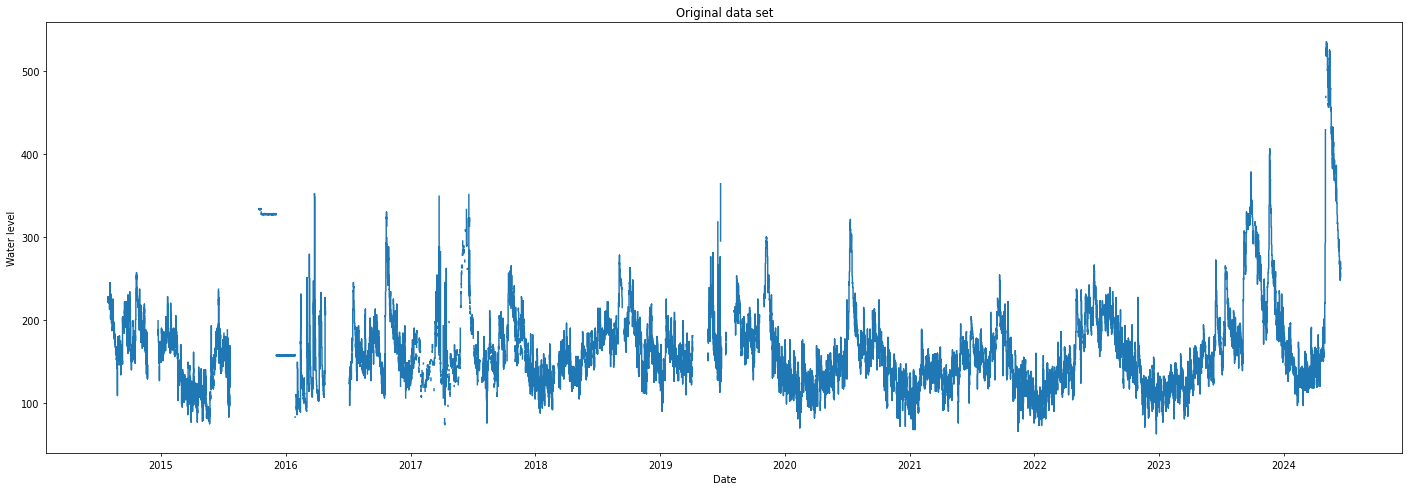

In [18]:
dataset_missing_data['date_time'] = pd.to_datetime(dataset_missing_data['date_time'])
dataset_missing_data.set_index('date_time', inplace=True)

plot_dataset(dataset_missing_data.index.date, dataset_missing_data['level_cm'], 'Date', 'Water level', f'Original data set', figsize=(25, 8), dpi=70)

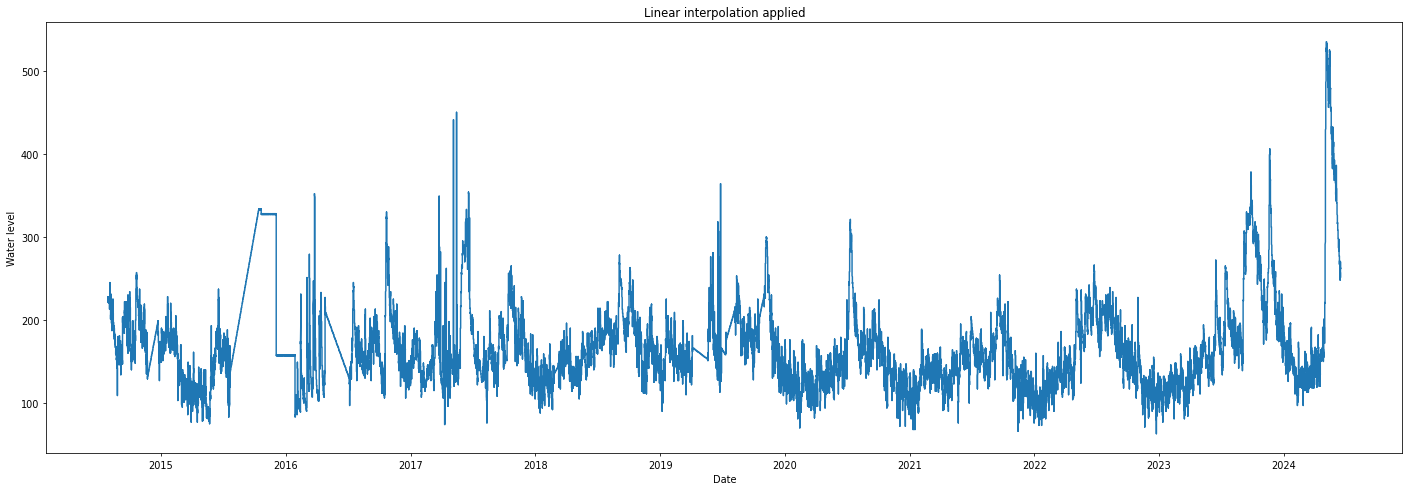

In [19]:
plot_dataset(dataset.index.date, dataset['level_cm'], 'Date', 'Water level', f'Linear interpolation applied', figsize=(25, 8), dpi=70)

### Selecting time

In [20]:
# Definir a faixa de datas
start_date = '2019-08-01'

# Selecionar os dados dentro da faixa de datas
df_filtered = dataset[start_date:]

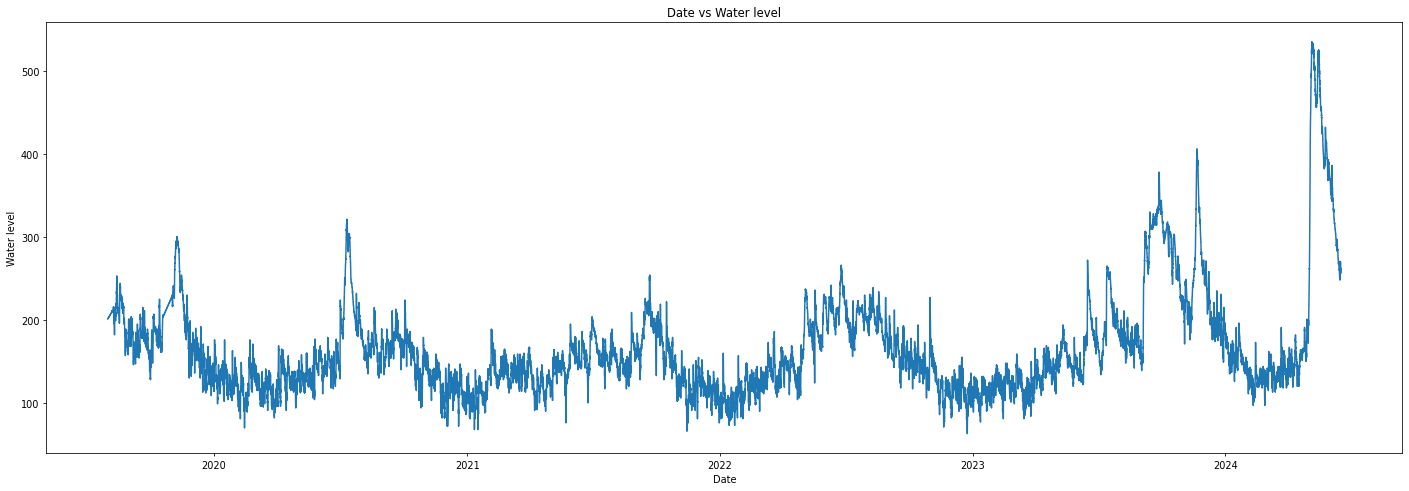

In [21]:
plot_dataset(df_filtered.index, df_filtered['level_cm'], 'Date', 'Water level', f'Date vs Water level', figsize=(25, 8), dpi=70)

### Grouping the data by day

In [22]:
df_daily_mean = df_filtered.resample('D').mean()
df_daily_mean

,level_cm
date_time,
2019-08-01,202.208333
2019-08-02,203.541667
2019-08-03,204.968750
2019-08-04,206.427083
2019-08-05,207.729167
...,...
2024-06-12,270.854167
2024-06-13,263.791667
2024-06-14,252.802083


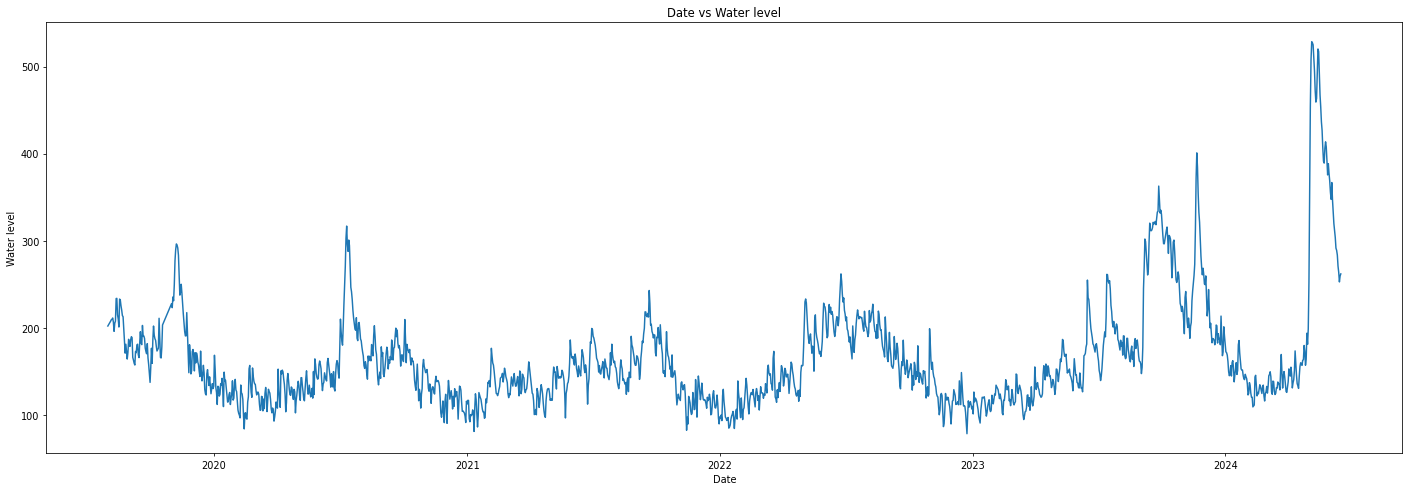

In [23]:
plot_dataset(df_daily_mean.index, df_daily_mean['level_cm'], 'Date', 'Water level', f'Date vs Water level', figsize=(25, 8), dpi=70)

## Time Series Decomposition

In [24]:
['mm/h_lag_1', 'level_cm_lag_1', 'temperature_lag_1']

['mm/h_lag_1', 'level_cm_lag_1', 'temperature_lag_1']

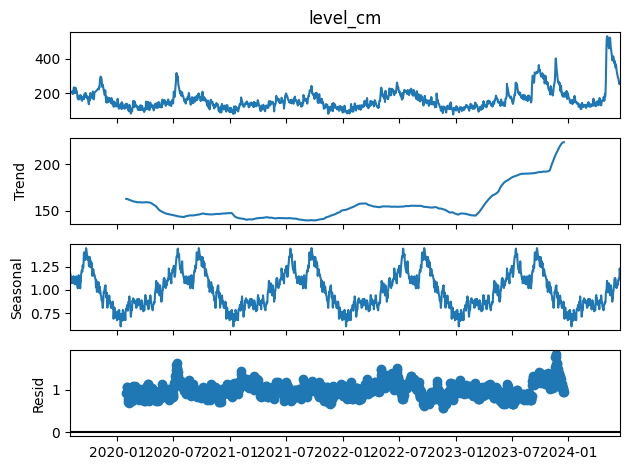

In [25]:
result = seasonal_decompose(df_daily_mean['level_cm'], model='multiplicative', period=365)
result.plot()
plt.show()

<Axes: xlabel='date_time'>

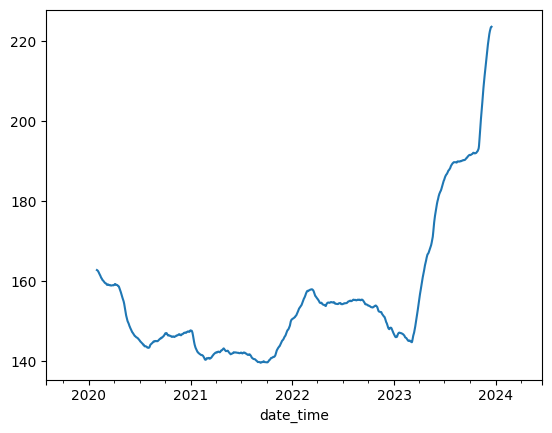

In [26]:
result.trend.plot()

<Axes: xlabel='date_time'>

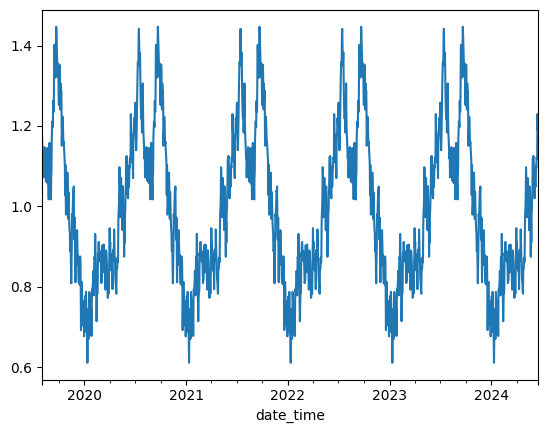

In [27]:
result.seasonal.plot()

<Axes: xlabel='date_time'>

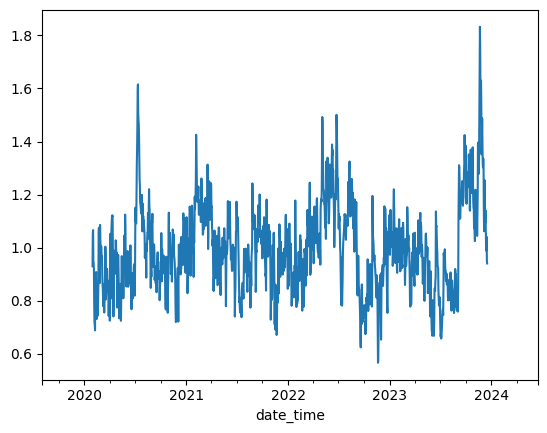

In [28]:
residual = result.resid
residual.plot()

## Making the series stationary

In [29]:
def plot_autocorrelation(value, lags=1):
  plot_acf(value, lags=lags)
  plot_pacf(value, lags=lags, method = "ols")

Dickey–Fuller test

In [30]:
def check_stationarity(df):
  result = adfuller(df)

  print('-- Dickey–Fuller test --')
  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  print('Critical values: ')
  for key, value in result[4].items():
    print('\t%s: %3f' % (key, value))
print('\n\n')

### Checking for stationarity

In [31]:
print("Level_cm")
check_stationarity(df_daily_mean['level_cm'])

Level_cm
-- Dickey–Fuller test --
ADF Statistic: -4.519272
p-value: 0.000181
Critical values: 
	1%: -3.434031
	5%: -2.863166
	10%: -2.567636


### Transforming data using differentiation

In [32]:
df_lag = pd.DataFrame()

df_lag['level_cm_lag_1'] = df_daily_mean['level_cm'] - df_daily_mean['level_cm'].shift(1)

df_lag.dropna(inplace=True)
df_lag

,level_cm_lag_1
date_time,
2019-08-02,1.333333
2019-08-03,1.427083
2019-08-04,1.458333
2019-08-05,1.302083
2019-08-06,1.645833
...,...
2024-06-12,-12.781250
2024-06-13,-7.062500
2024-06-14,-10.989583


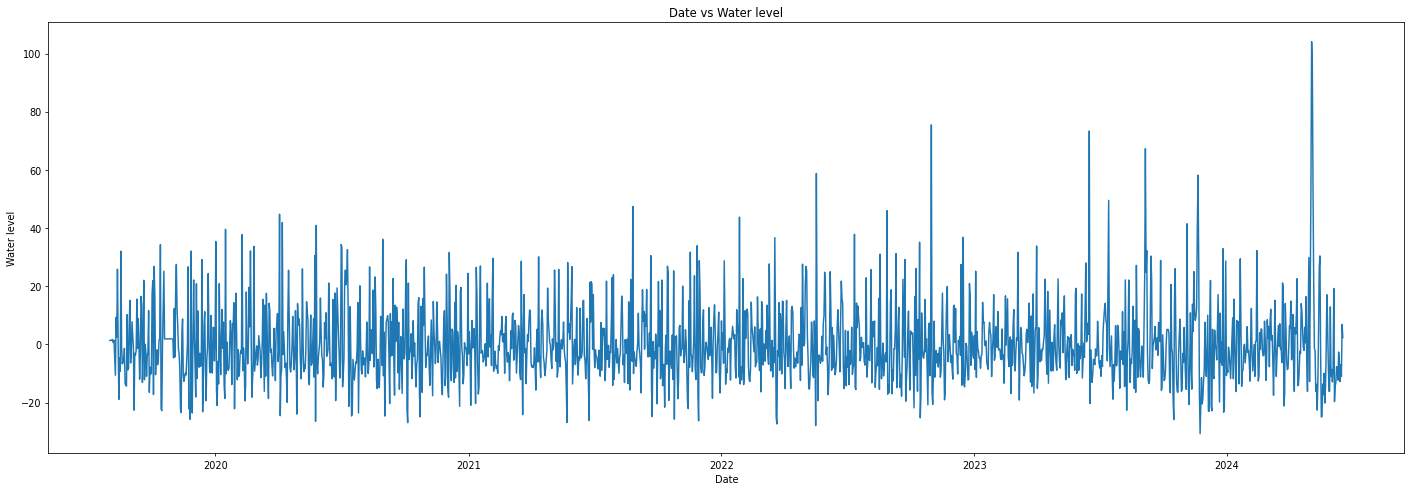

In [33]:
plot_dataset(df_lag.index, df_lag['level_cm_lag_1'], 'Date', 'Water level', f'Date vs Water level', figsize=(25, 8), dpi=70)

#### Checking transformed data

In [34]:
print("Level_cm")
check_stationarity(df_lag['level_cm_lag_1'])

Level_cm
-- Dickey–Fuller test --
ADF Statistic: -31.657542
p-value: 0.000000
Critical values: 
	1%: -3.434031
	5%: -2.863166
	10%: -2.567636


**Using ACF and PACF level_cm**

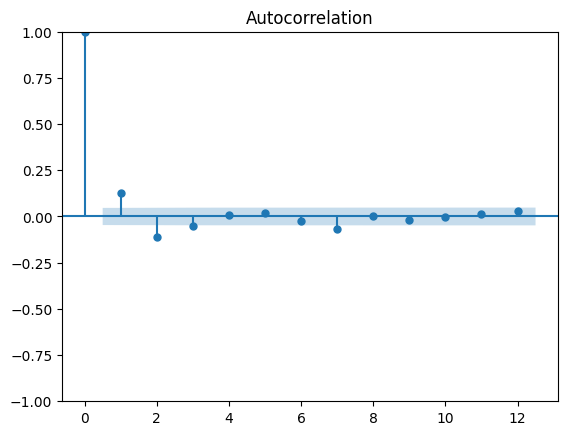

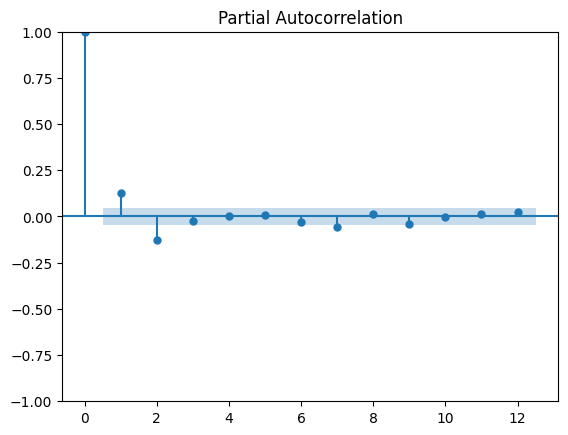

In [35]:
plot_acf(df_lag['level_cm_lag_1'], lags=12)
plot_pacf(df_lag['level_cm_lag_1'], lags=12, method="ols")
plt.show()

In [36]:
check_negatives_values(df_lag['level_cm_lag_1'])

There are negative values in the dataset.


### Log transformation

In [37]:
dataset_log = np.log(df_daily_mean['level_cm'])
dataset_log = dataset_log.diff().dropna()

dataset_log

,level_cm
date_time,
2019-08-02,0.006572
2019-08-03,0.006987
2019-08-04,0.007090
2019-08-05,0.006288
2019-08-06,0.007892
...,...
2024-06-12,-0.046109
2024-06-13,-0.026421
2024-06-14,-0.042553


In [38]:
dataset_log = pd.DataFrame()

dataset_log['level_cm'] = np.log(df_daily_mean['level_cm'])

dataset_log.dropna(inplace=True)
dataset_log

,level_cm
date_time,
2019-08-01,5.309299
2019-08-02,5.315871
2019-08-03,5.322858
2019-08-04,5.329947
2019-08-05,5.336235
...,...
2024-06-12,5.601581
2024-06-13,5.575160
2024-06-14,5.532607


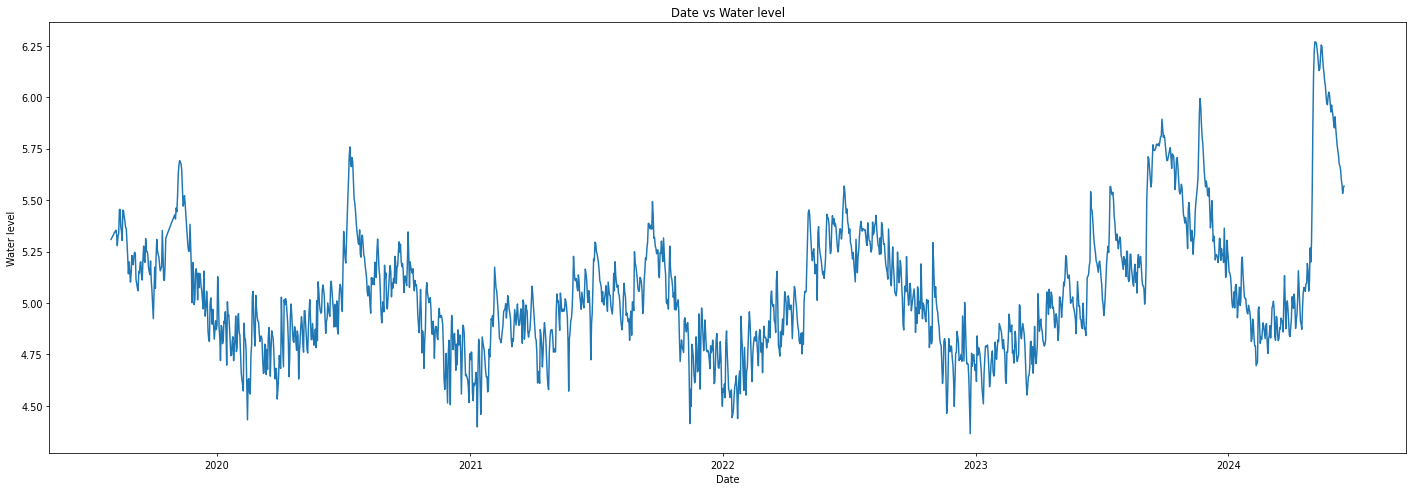

In [39]:
plot_dataset(dataset_log.index, dataset_log['level_cm'], 'Date', 'Water level', f'Date vs Water level', figsize=(25, 8), dpi=70)

#### Checking transformed data

In [40]:
check_stationarity(dataset_log['level_cm'])

-- Dickey–Fuller test --
ADF Statistic: -3.794317
p-value: 0.002966
Critical values: 
	1%: -3.434042
	5%: -2.863171
	10%: -2.567638


**Using ACF and PACF level_cm**

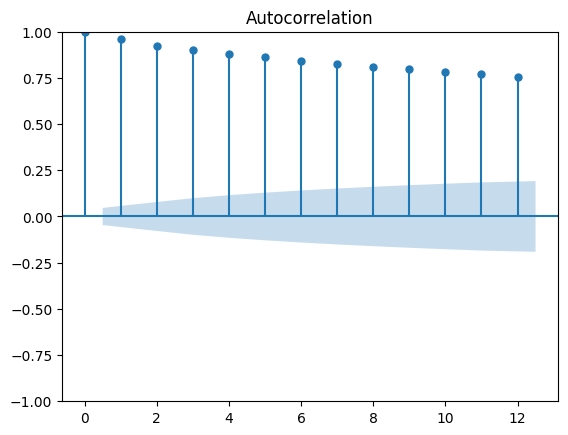

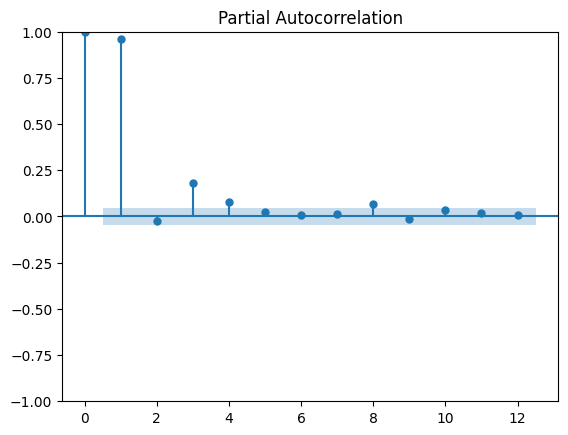

In [41]:
plot_acf(dataset_log['level_cm'], lags=12)
plot_pacf(dataset_log['level_cm'], lags=12, method="ols")
plt.show()

In [42]:
check_negatives_values(dataset_log['level_cm'])

There are no negative values in the dataset.


# Training the model

## Scaling the data

In [43]:
data = dataset_log['level_cm'].values
data

array([5.30929852, 5.31587073, 5.32285753, ..., 5.5326069 , 5.5592784 ,
       5.5683445 ])

In [44]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(dataset_log).flatten()
data_scaled

array([0.49577601, 0.49922542, 0.50289243, ..., 0.61297896, 0.62697744,
       0.63173577])

In [45]:
df_scaled = pd.DataFrame()
df_scaled['level_cm_lag_1_scaled'] = data_scaled
df_scaled.index = dataset_log.index
df_scaled

,level_cm_lag_1_scaled
date_time,
2019-08-01,0.495776
2019-08-02,0.499225
2019-08-03,0.502892
2019-08-04,0.506613
2019-08-05,0.509914
...,...
2024-06-12,0.649180
2024-06-13,0.635313
2024-06-14,0.612979


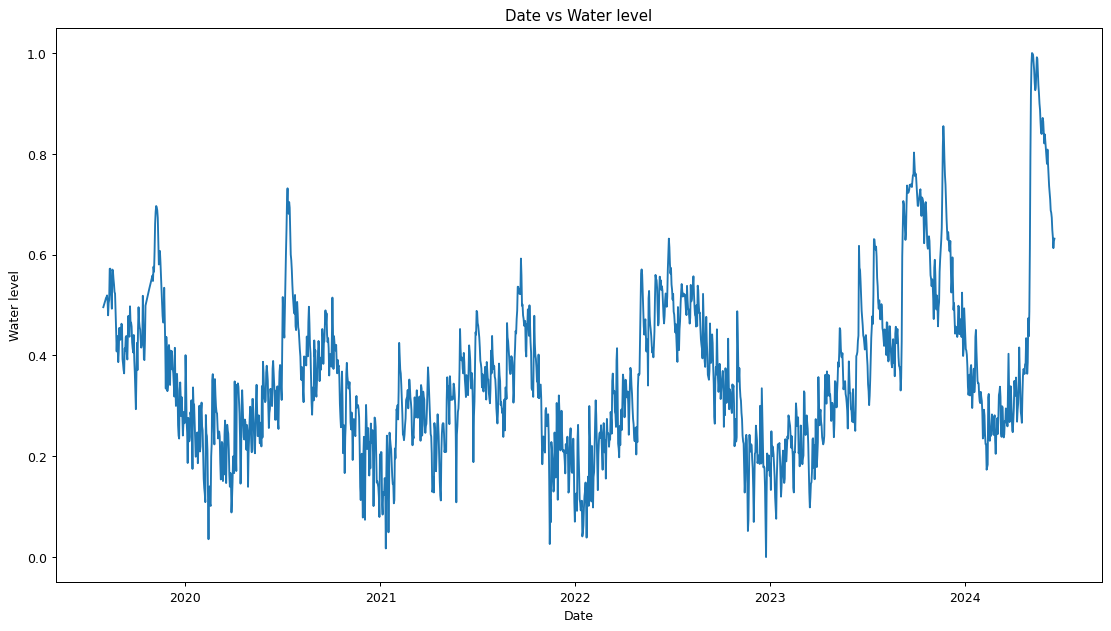

In [46]:
plot_dataset(df_scaled.index, df_scaled['level_cm_lag_1_scaled'], 'Date', 'Water level', f'Date vs Water level', figsize=(15, 8), dpi=90)

In [47]:
start_date_train = '2023-01-01'

df_train = df_scaled[:start_date_train]
df_test = df_scaled[start_date_train:]

train_size = len(df_train)
test_size = len(df_test)

print("Train size: ", train_size)
print("Test size: ", test_size)

Train size:  1250
Test size:  533


In [48]:
# 67%
df_scaled.head(1091)

# 70% --> selecionado
df_scaled.head(1139)

,level_cm_lag_1_scaled
date_time,
2019-08-01,0.495776
2019-08-02,0.499225
2019-08-03,0.502892
2019-08-04,0.506613
2019-08-05,0.509914
...,...
2022-09-08,0.351734
2022-09-09,0.369365
2022-09-10,0.463437


In [49]:
df_train

,level_cm_lag_1_scaled
date_time,
2019-08-01,0.495776
2019-08-02,0.499225
2019-08-03,0.502892
2019-08-04,0.506613
2019-08-05,0.509914
...,...
2022-12-28,0.191763
2022-12-29,0.201704
2022-12-30,0.184181


In [50]:
df_test = df_test.drop(df_test.index[0])
df_test

,level_cm_lag_1_scaled
date_time,
2023-01-02,0.133113
2023-01-03,0.249506
2023-01-04,0.200187
2023-01-05,0.219898
2023-01-06,0.214659
...,...
2024-06-12,0.649180
2024-06-13,0.635313
2024-06-14,0.612979


## AUTO ARIMA

In [ ]:
# Ajustar o modelo auto_arima
model = auto_arima(df_train,
                   start_p=1,
                   start_q=1,
                   max_p=2,
                   max_q=2,
                   start_P=1,
                   start_Q=1,
                   D=0,
                   max_P=3,
                   max_D=3,
                   max_Q=3,
                   max_order=5,
                   m=365,
                   seasonal=True,
                   stepwise=True,
                   trace=True)

# Imprimir o resumo do modelo
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[365] intercept   : AIC=inf, Time=1754.89 sec
 ARIMA(0,0,0)(0,0,0)[365] intercept   : AIC=-2063.844, Time=0.14 sec


KeyboardInterrupt: 

In [ ]:
n_periods = len(df_test)  # número de períodos para prever
forecast, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)
forecast

In [ ]:
forecast.values

In [ ]:
plot_dataset(df_test.index, forecast.values, 'Date', 'Water level', f'Date vs Water level', figsize=(15, 8), dpi=90)

In [ ]:
plt.figure(figsize=(19, 4))
plt.plot(df_test.index, df_test['level_cm_lag_1_scaled'])
plt.plot(df_test.index, forecast.values, 'red')
plt.legend(["Forecast", "Origin"])
plt.xlabel("Years")
plt.title("Forecast using ARIMA - Test")

### Undoing the scale transformation

In [ ]:
forecast = forecast.values
test_data = np.array(df_test['level_cm_lag_1_scaled'])

forecast_inversed = scaler.inverse_transform(forecast.reshape(0, 1))
test_inversed = scaler.inverse_transform(test_data.reshape(0, 1))

In [ ]:
plt.figure(figsize=(19, 4))
plt.plot(df_test.index, test_inversed)
plt.plot(df_test.index, forecast_inversed, 'red')
plt.legend(["Forecast", "Origin"])
plt.xlabel("Years")
plt.title("Forecast using ARIMA - Test")

### Calculating error

In [ ]:
def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [ ]:
print("MSE: ", mean_squared_error(test_inversed, forecast_inversed))

In [ ]:
print("RMSE: ", root_mean_squared_error(test_inversed, forecast_inversed))

##LSTM - TATP

### Stationary data

In [ ]:
data_scaled = data_scaled.reshape(-1, 1)
data_scaled.shape

(1782, 1)

In [ ]:
# split into train and test sets
train_size = int(len(data_scaled) * 0.80)
test_size = len(data_scaled) - train_size

train, test = data_scaled[0:train_size,:], data_scaled[train_size:len(data_scaled),:]
print("Treino:", len(train))
print("Teste:", len(test))

Treino: 1425
Teste: 357


In [ ]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []

    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])

    return np.array(dataX), np.array(dataY)

In [ ]:
# reshape into X=t and Y=t+1
look_back = 5
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
for index in range(5):
    print(trainX[index], trainY[index])

[0.49577601 0.49922542 0.50289243 0.50661345 0.50991364] 0.5140556135705929
[0.49922542 0.50289243 0.50661345 0.50991364 0.51405561] 0.5156199901797716
[0.50289243 0.50661345 0.50991364 0.51405561 0.51561999] 0.5191228816950013
[0.50661345 0.50991364 0.51405561 0.51561999 0.51912288] 0.5073015996955657
[0.50991364 0.51405561 0.51561999 0.51912288 0.5073016 ] 0.47966020539250653


In [ ]:
print("Train X shape: ", trainX.shape)
print("Train Y shape: ", trainY.shape)

Train X shape:  (1419, 5)
Train Y shape:  (1419,)


In [ ]:
print("Test X shape: ", testX.shape)
print("Test Y shape: ", testY.shape)

Test X shape:  (351, 5)
Test Y shape:  (351,)


In [ ]:
trainX.shape

(1419, 5)

In [ ]:
test = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
test.shape

(1419, 5, 1)

In [ ]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model = Sequential()
model.add(LSTM(4, input_shape=(look_back, 1),  kernel_regularizer=l2(0.001)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mean_squared_error'])
model.summary()

model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2, validation_data=(testX, testY), callbacks=[early_stopping])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 4)                   │              96 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 4)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 101 (404.00 B)

 Trainable params: 101 (404.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1419/1419 - 7s - 5ms/step - loss: 0.0179 - mean_squared_error: 0.0162 - val_loss: 0.0143 - val_mean_squared_error: 0.0132
Epoch 2/10
1419/1419 - 4s - 3ms/step - loss: 0.0065 - mean_squared_error: 0.0056 - val_loss: 0.0056 - val_mean_squared_error: 0.0050
Epoch 3/10
1419/1419 - 4s - 3ms/step - loss: 0.0051 - mean_squared_error: 0.0046 - val_loss: 0.0047 - val_mean_squared_error: 0.0042
Epoch 4/10
1419/1419 - 4s - 3ms/step - loss: 0.0047 - mean_squared_error: 0.0042 - val_loss: 0.0041 - val_mean_squared_error: 0.0037
Epoch 5/10
1419/1419 - 5s - 3ms/step - loss: 0.0043 - mean_squared_error: 0.0039 - val_loss: 0.0047 - val_mean_squared_error: 0.0043
Epoch 6/10
1419/1419 - 4s - 3ms/step - loss: 0.0042 - mean_squared_error: 0.0038 - val_loss: 0.0037 - val_mean_squared_error: 0.0033
Epoch 7/10
1419/1419 - 4s - 3ms/step - loss: 0.0040 - mean_squared_error: 0.0036 - val_loss: 0.0039 - val_mean_squared_error: 0.0035
Epoch 8/10
1419/1419 - 4s - 3ms/step - loss: 0.0039 - mean_squared_er

In [ ]:
# # create and fit the LSTM network
# model = Sequential()
# model.add(LSTM(1, activation='tanh', input_shape=(look_back, 1)))
# model.add(Dropout(0.2))
# model.add(Dense(1, activation='tanh'))
# model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
# model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2, validation_data=(testX, testY))

# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# model = Sequential()
# model.add(GRU(1, activation='tanh', input_shape=(look_back, 1), kernel_regularizer=l2(0.001)))
# model.add(Dropout(0.2))
# model.add(Dense(1, activation='tanh'))

# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mean_squared_error'])
# model.summary()

# model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2, validation_data=(testX, testY), callbacks=[early_stopping])

Predição

In [ ]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


invert predictions

In [ ]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])

testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [ ]:
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f MSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.10 MSE
Test Score: 0.10 RMSE


In [ ]:
index_train = np.arange(0, len(trainPredict))
index_train_normal = np.arange(0, len(trainY))
index_test_normal = np.arange(0, len(testY))
index_test = np.arange(0, len(testPredict))

Text(0.5, 1.0, 'Forecast using Train data')

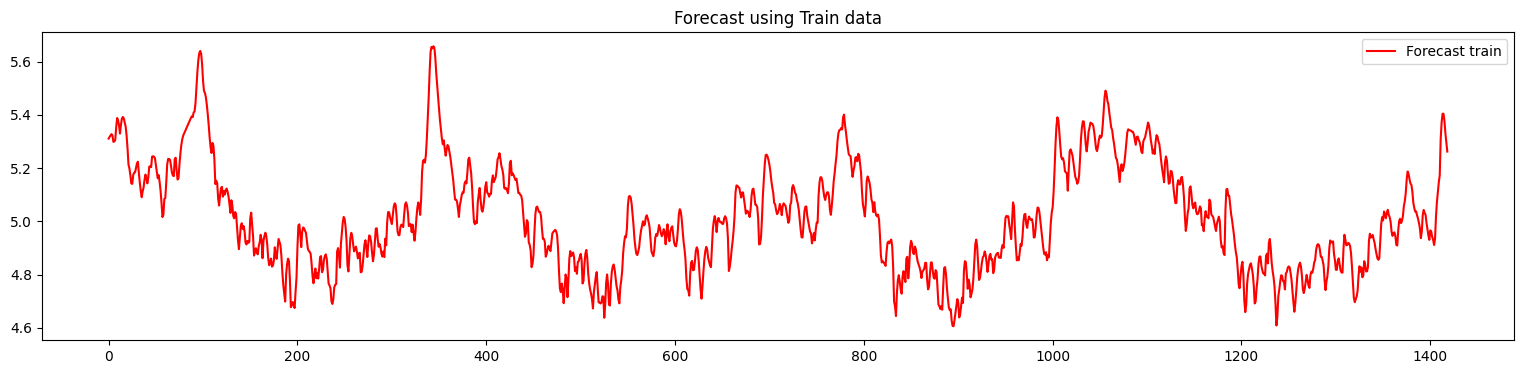

In [ ]:
plt.figure(figsize=(19, 4))
#plt.plot(index_test_normal, test_y_normal)
plt.plot(index_train, trainPredict, 'red')
plt.legend(["Forecast train"])
plt.title("Forecast using Train data")

Text(0.5, 1.0, 'Forecast using test data')

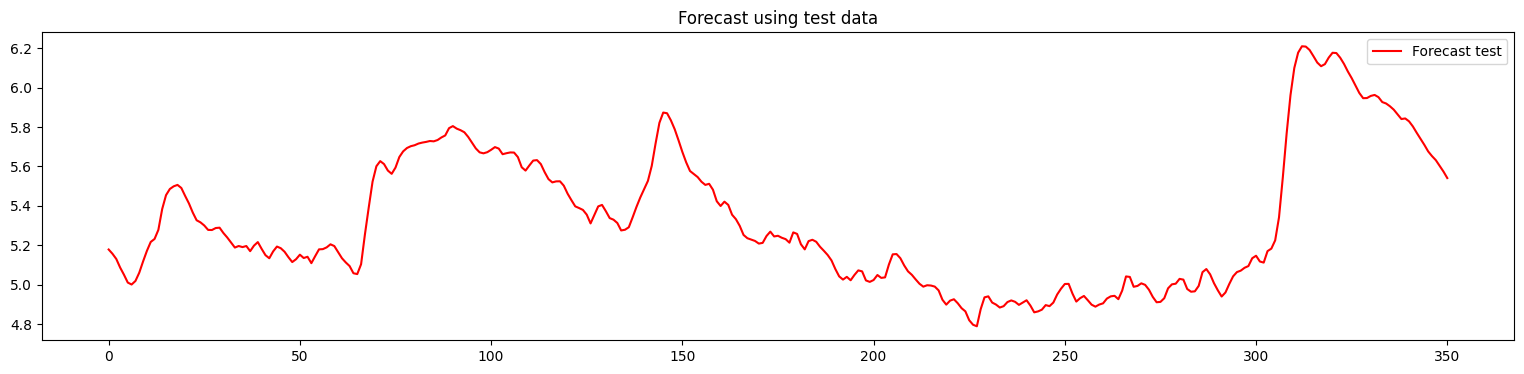

In [ ]:
plt.figure(figsize=(19, 4))
#plt.plot(index_test_normal, test_y_normal)
plt.plot(index_test, testPredict, 'red')
plt.legend(["Forecast test"])
plt.title("Forecast using test data")

Shift the predictions

In [ ]:
# shift traing predictions for plotting
trainPredictPlot = np.empty_like(data_scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(data_scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(data_scaled)-1, :] = testPredict

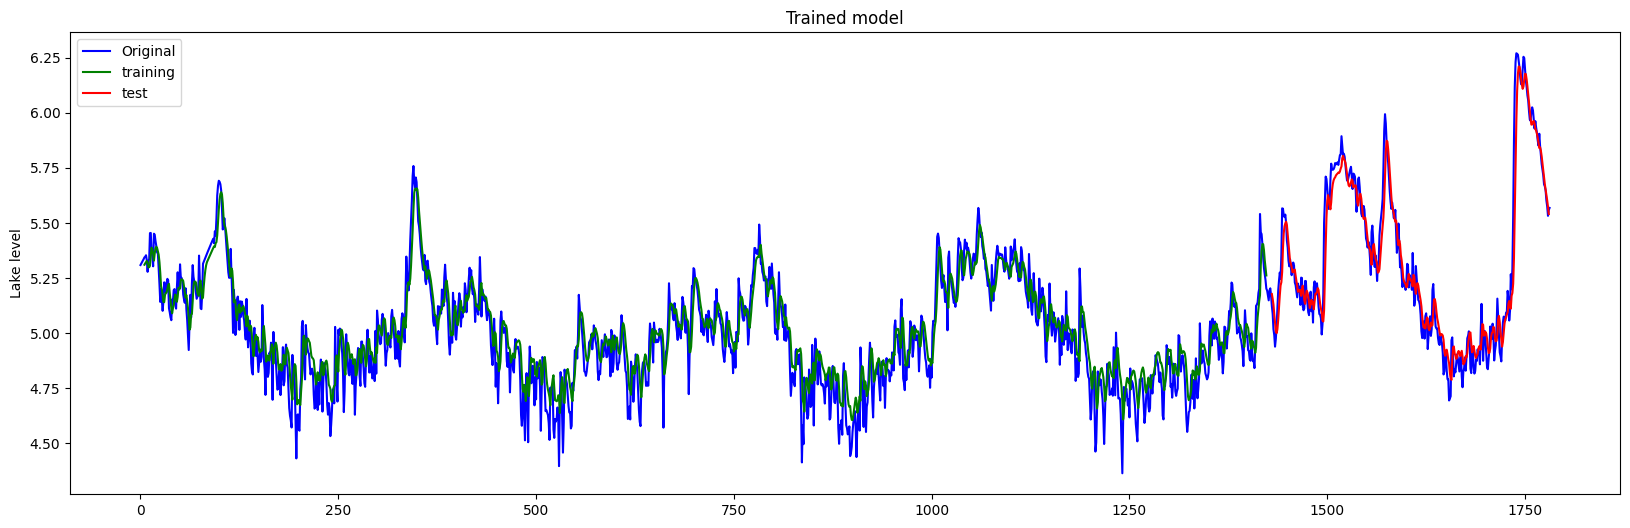

In [ ]:
# plot baseline and predictions
plt.figure(figsize=(20, 6))
plt.plot(scaler.inverse_transform(data_scaled), color='blue')
plt.plot(trainPredictPlot, color="green")
plt.plot(testPredictPlot, color='red')
plt.legend(["Original", "training", "test"])
plt.ylabel("Lake level")
plt.title("Trained model")
plt.show()

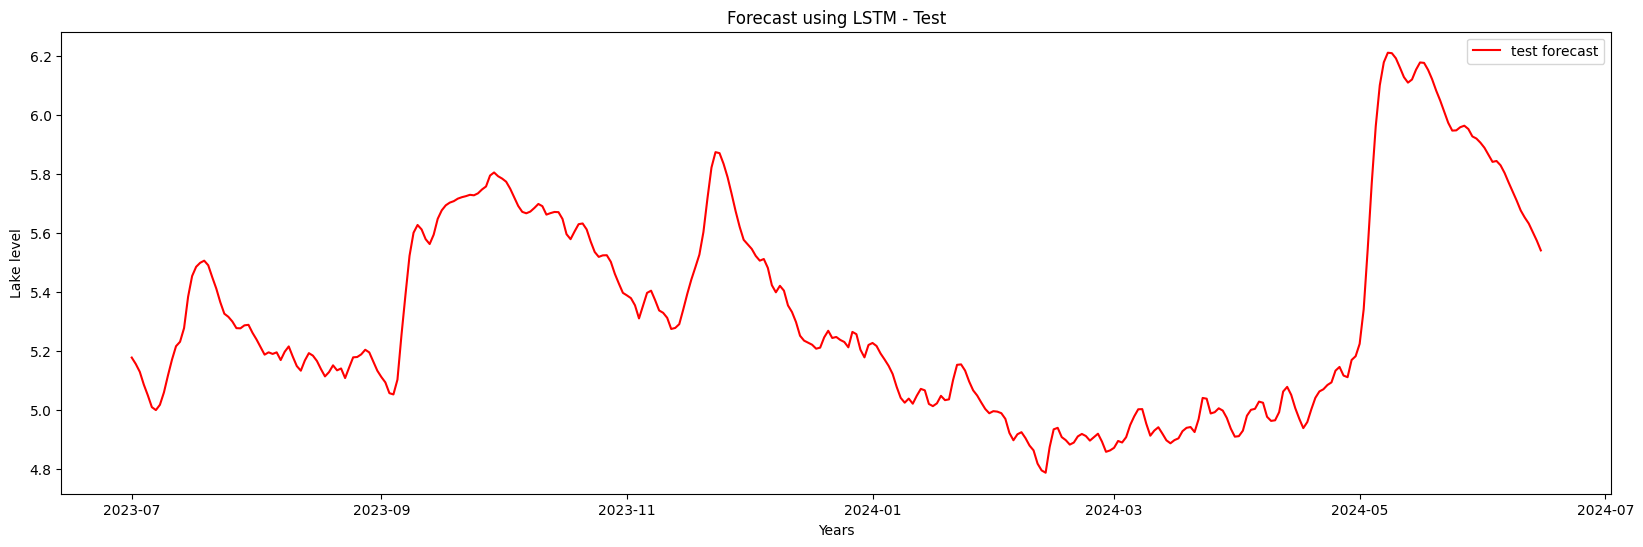

In [ ]:
# plot baseline and predictions
plt.figure(figsize=(20, 6))
plt.plot(df_daily_mean.index, testPredictPlot, color='red')
plt.legend(["test forecast"])
plt.xlabel("Years")
plt.ylabel("Lake level")
plt.title("Forecast using LSTM - Test")
plt.show()

Prediction

### Non-stationary data

In [51]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(df_daily_mean.values)
data_scaled

array([[0.27471866],
       [0.27768258],
       [0.28085491],
       ...,
       [0.38718566],
       [0.40237577],
       [0.4076321 ]])

In [52]:
# split into train and test sets
train_size = int(len(data_scaled) * 0.80)
test_size = len(data_scaled) - train_size

train, test = data_scaled[0:train_size,:], data_scaled[train_size:len(data_scaled),:]
print("Treino:", len(train))
print("Teste:", len(test))

Treino: 1425
Teste: 357


In [53]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []

    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])

    return np.array(dataX), np.array(dataY)

In [54]:
# reshape into X=t and Y=t+1
look_back = 5
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [55]:
for index in range(5):
    print(trainX[index], trainY[index])

[0.27471866 0.27768258 0.28085491 0.2840967  0.28699115] 0.29064974760339
[0.27768258 0.28085491 0.2840967  0.28699115 0.29064975] 0.2920390867410735
[0.28085491 0.2840967  0.28699115 0.29064975 0.29203909] 0.29516509980086136
[0.2840967  0.28699115 0.29064975 0.29203909 0.2951651 ] 0.28469874496364556
[0.28699115 0.29064975 0.29203909 0.2951651  0.28469874] 0.2611262909276154


In [56]:
print("Train X shape: ", trainX.shape)
print("Train Y shape: ", trainY.shape)

Train X shape:  (1419, 5)
Train Y shape:  (1419,)


In [57]:
print("Test X shape: ", testX.shape)
print("Test Y shape: ", testY.shape)

Test X shape:  (351, 5)
Test Y shape:  (351,)


In [58]:
test = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
test.shape

(1419, 5, 1)

In [59]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [60]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model = Sequential()
model.add(LSTM(4, input_shape=(look_back, 1),  kernel_regularizer=l2(0.001)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mean_squared_error'])
model.summary()

model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2, validation_data=(testX, testY), callbacks=[early_stopping])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 4)                   │              96 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 4)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 101 (404.00 B)

 Trainable params: 101 (404.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1419/1419 - 4s - 3ms/step - loss: 0.0061 - mean_squared_error: 0.0057 - val_loss: 0.0108 - val_mean_squared_error: 0.0105
Epoch 2/10
1419/1419 - 2s - 2ms/step - loss: 0.0026 - mean_squared_error: 0.0023 - val_loss: 0.0070 - val_mean_squared_error: 0.0067
Epoch 3/10
1419/1419 - 3s - 2ms/step - loss: 0.0021 - mean_squared_error: 0.0019 - val_loss: 0.0075 - val_mean_squared_error: 0.0072
Epoch 4/10
1419/1419 - 5s - 4ms/step - loss: 0.0021 - mean_squared_error: 0.0019 - val_loss: 0.0065 - val_mean_squared_error: 0.0063
Epoch 5/10
1419/1419 - 2s - 2ms/step - loss: 0.0020 - mean_squared_error: 0.0018 - val_loss: 0.0070 - val_mean_squared_error: 0.0068
Epoch 6/10
1419/1419 - 3s - 2ms/step - loss: 0.0020 - mean_squared_error: 0.0018 - val_loss: 0.0052 - val_mean_squared_error: 0.0049
Epoch 7/10
1419/1419 - 2s - 2ms/step - loss: 0.0019 - mean_squared_error: 0.0017 - val_loss: 0.0053 - val_mean_squared_error: 0.0050
Epoch 8/10
1419/1419 - 3s - 2ms/step - loss: 0.0019 - mean_squared_er

Predição

In [61]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


invert predictions

In [62]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])

testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

shift data

In [63]:
# shift traing predictions for plotting
trainPredictPlot = np.empty_like(data_scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(data_scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(data_scaled)-1, :] = testPredict

Accuracy

In [64]:
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f MSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 18.49 MSE
Test Score: 27.46 RMSE


####Plot results

In [65]:
def plot_result(dataset, predict, size, title, legend_1, legend_2, color_1 = 'royalblue', color_2 = 'orangered', linestyle_1 = '-', linestyle_2 = '--'):
    plt.figure(figsize=(19, 4))
    plt.plot(dataset.tail(size).index, dataset.tail(size)['level_cm'], color=color_1, linestyle=linestyle_1)
    plt.plot(dataset.tail(size).index, predict[-size:], color=color_2, linestyle=linestyle_2)
    plt.legend([legend_1, legend_2])
    plt.title(title)

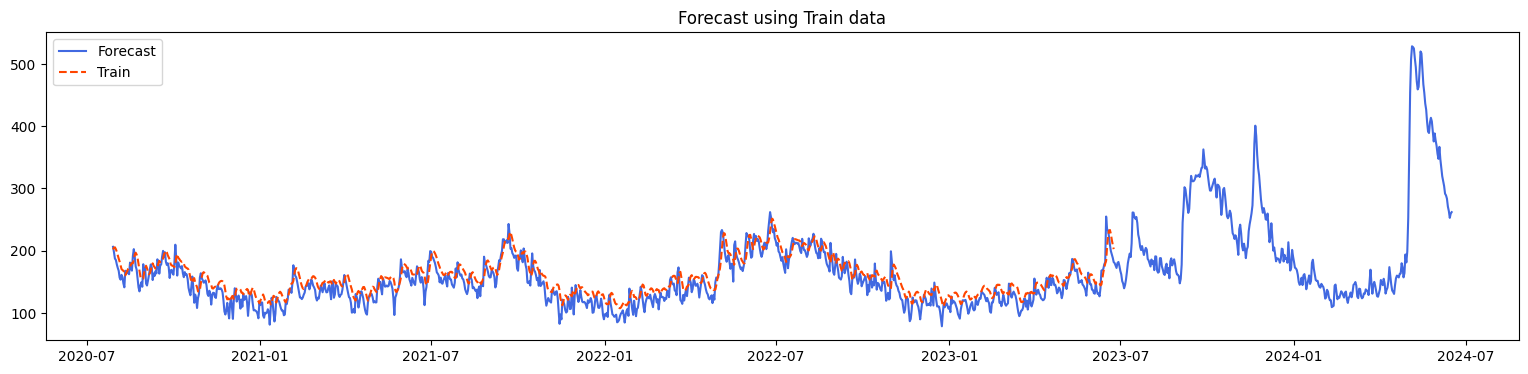

In [66]:
plot_result(df_daily_mean,
            trainPredictPlot,
            trainPredict.shape[0],
            "Forecast using Train data",
            "Forecast",
            "Train")

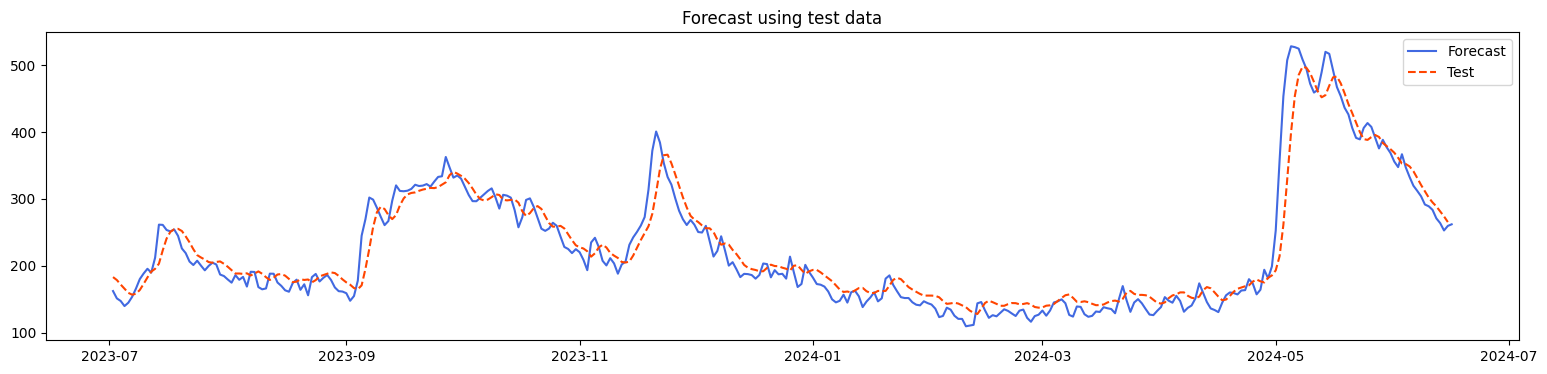

In [67]:
plot_result(df_daily_mean,
            testPredictPlot,
            testPredict.shape[0],
            "Forecast using test data",
            "Forecast",
            "Test")

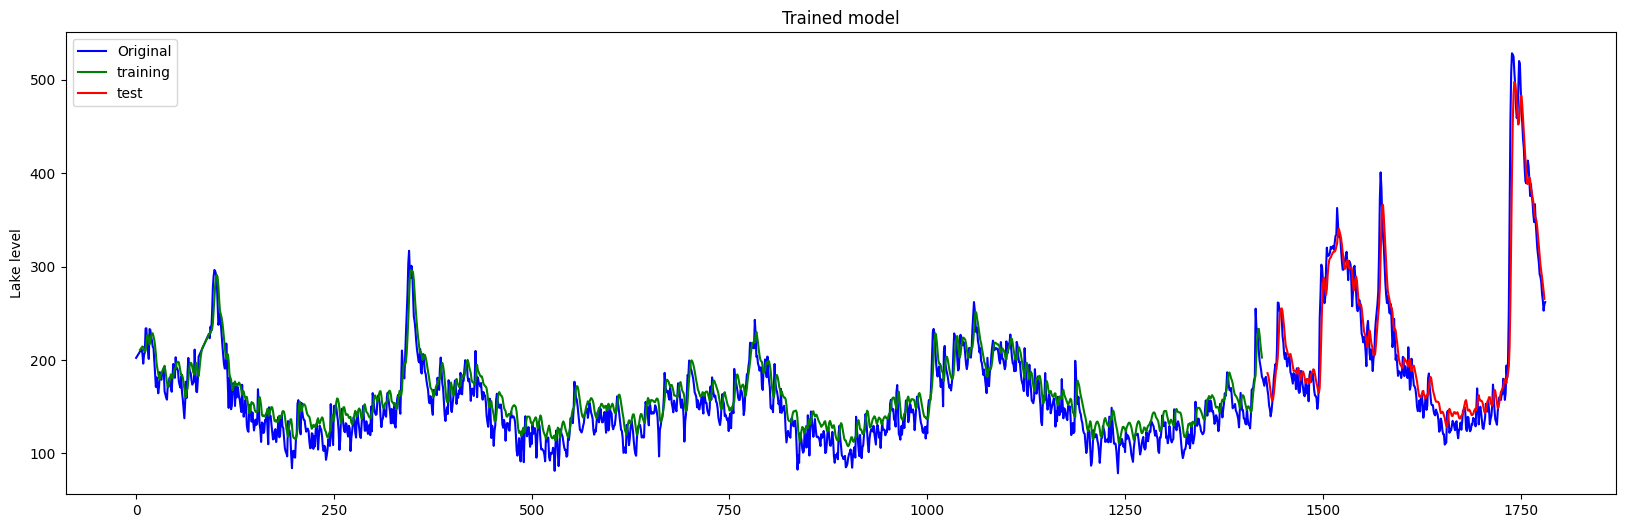

In [68]:
# plot baseline and predictions
plt.figure(figsize=(20, 6))
plt.plot(scaler.inverse_transform(data_scaled), color='blue')
plt.plot(trainPredictPlot, color="green")
plt.plot(testPredictPlot, color='red')
plt.legend(["Original", "training", "test"])
plt.ylabel("Lake level")
plt.title("Trained model")
plt.show()

####Predição

##GRU - TATP

###Stationary data

In [ ]:
data_scaled = data_scaled.reshape(-1, 1)
data_scaled.shape

(1629, 1)

In [ ]:
data_scaled.shape

(1629, 1)

In [ ]:
# split into train and test sets
train_size = int(len(data_scaled) * 0.80)
test_size = len(data_scaled) - train_size

train, test = data_scaled[0:train_size,:], data_scaled[train_size:len(data_scaled),:]
print("Treino:", len(train))
print("Teste:", len(test))

Treino: 1303
Teste: 326


In [ ]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []

    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])

    return np.array(dataX), np.array(dataY)

In [ ]:
# reshape into X=t and Y=t+1
look_back = 5
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
for index in range(5):
    print(trainX[index], trainY[index])

[0.12149771 0.2001343  0.16454407 0.11774649 0.10484879 0.07463067
 0.12101144 0.11913583 0.09593387 0.10065762 0.12728662 0.12425323
 0.1413421  0.11049877 0.06914278 0.15708795 0.13460381 0.1364331
 0.11860325 0.0987357  0.08062798 0.08155421 0.09968508 0.10517297
 0.07444542 0.09044598 0.1030195  0.13492799 0.08572222 0.090747
 0.1298569  0.13860973 0.11154078 0.10751169 0.08301301 0.06015838
 0.05205391 0.04733015 0.04033715 0.12425323 0.10415412 0.10128282
 0.08729681 0.04408836 0.01220303 0.05226231 0.05355902 0.03866994
 0.03723429 0.08081323 0.0942435  0.16567869 0.17415366 0.1337702
 0.1058908  0.09280785 0.16769323 0.14722364 0.13383967 0.12726347
 0.12610568 0.11024406] 0.0989209466030658
[0.2001343  0.16454407 0.11774649 0.10484879 0.07463067 0.12101144
 0.11913583 0.09593387 0.10065762 0.12728662 0.12425323 0.1413421
 0.11049877 0.06914278 0.15708795 0.13460381 0.1364331  0.11860325
 0.0987357  0.08062798 0.08155421 0.09968508 0.10517297 0.07444542
 0.09044598 0.1030195  0

In [ ]:
print("Train X shape: ", trainX.shape)
print("Train Y shape: ", trainY.shape)

Train X shape:  (1240, 62)
Train Y shape:  (1240,)


In [ ]:
print("Test X shape: ", testX.shape)
print("Test Y shape: ", testY.shape)

Test X shape:  (263, 62)
Test Y shape:  (263,)


In [ ]:
trainX.shape

(1240, 62)

In [ ]:
test = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
test.shape

(1240, 62, 1)

In [ ]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model = Sequential()
model.add(GRU(1, activation='tanh', input_shape=(look_back, 1), kernel_regularizer=l2(0.001)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='tanh'))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mean_squared_error'])
model.summary()

model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2, validation_data=(testX, testY), callbacks=[early_stopping])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                          │ (None, 1)                   │              12 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │               2 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14 (56.00 B)

 Trainable params: 14 (56.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1240/1240 - 15s - 12ms/step - loss: 0.0063 - mean_squared_error: 0.0052 - val_loss: 0.0458 - val_mean_squared_error: 0.0452
Epoch 2/20
1240/1240 - 12s - 10ms/step - loss: 0.0034 - mean_squared_error: 0.0028 - val_loss: 0.0199 - val_mean_squared_error: 0.0192
Epoch 3/20
1240/1240 - 12s - 9ms/step - loss: 0.0027 - mean_squared_error: 0.0022 - val_loss: 0.0212 - val_mean_squared_error: 0.0207
Epoch 4/20
1240/1240 - 12s - 10ms/step - loss: 0.0022 - mean_squared_error: 0.0017 - val_loss: 0.0180 - val_mean_squared_error: 0.0176
Epoch 5/20
1240/1240 - 12s - 9ms/step - loss: 0.0024 - mean_squared_error: 0.0020 - val_loss: 0.0155 - val_mean_squared_error: 0.0152
Epoch 6/20
1240/1240 - 12s - 9ms/step - loss: 0.0024 - mean_squared_error: 0.0021 - val_loss: 0.0162 - val_mean_squared_error: 0.0159
Epoch 7/20
1240/1240 - 12s - 9ms/step - loss: 0.0022 - mean_squared_error: 0.0019 - val_loss: 0.0149 - val_mean_squared_error: 0.0146
Epoch 8/20
1240/1240 - 11s - 9ms/step - loss: 0.0022 - mean

Predição

In [ ]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [ ]:
trainPredict.shape

(1240, 1)

invert predictions

In [ ]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])

testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [ ]:
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f MSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 14.22 MSE
Test Score: 48.97 RMSE


In [ ]:
index_train = np.arange(0, len(trainPredict))
index_train_normal = np.arange(0, len(trainY))
index_test_normal = np.arange(0, len(testY))
index_test = np.arange(0, len(testPredict))

Text(0.5, 1.0, 'Forecast using Train data')

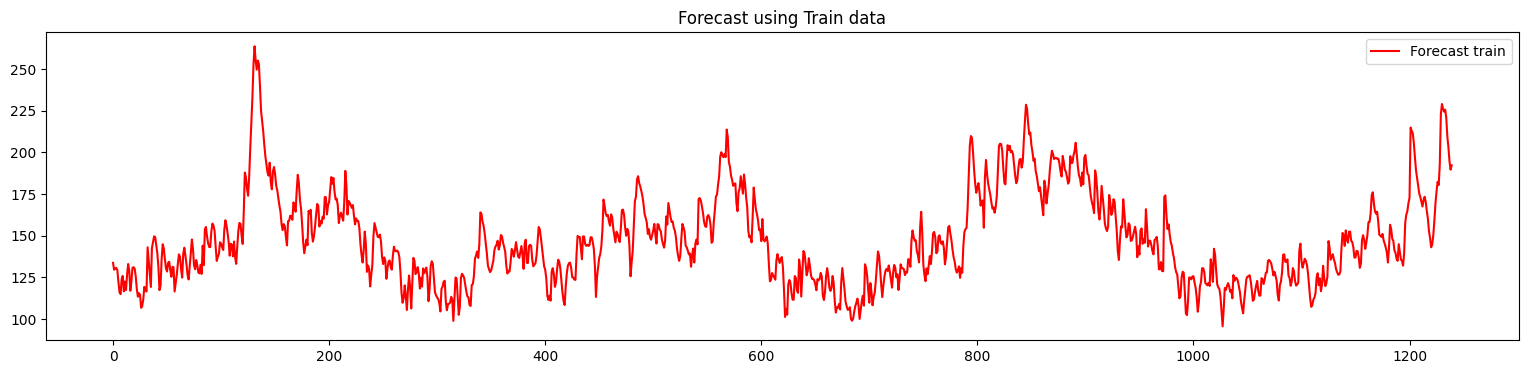

In [ ]:
plt.figure(figsize=(19, 4))
#plt.plot(index_test_normal, test_y_normal)
plt.plot(index_train, trainPredict, 'red')
plt.legend(["Forecast train"])
plt.title("Forecast using Train data")

Text(0.5, 1.0, 'Forecast using test data')

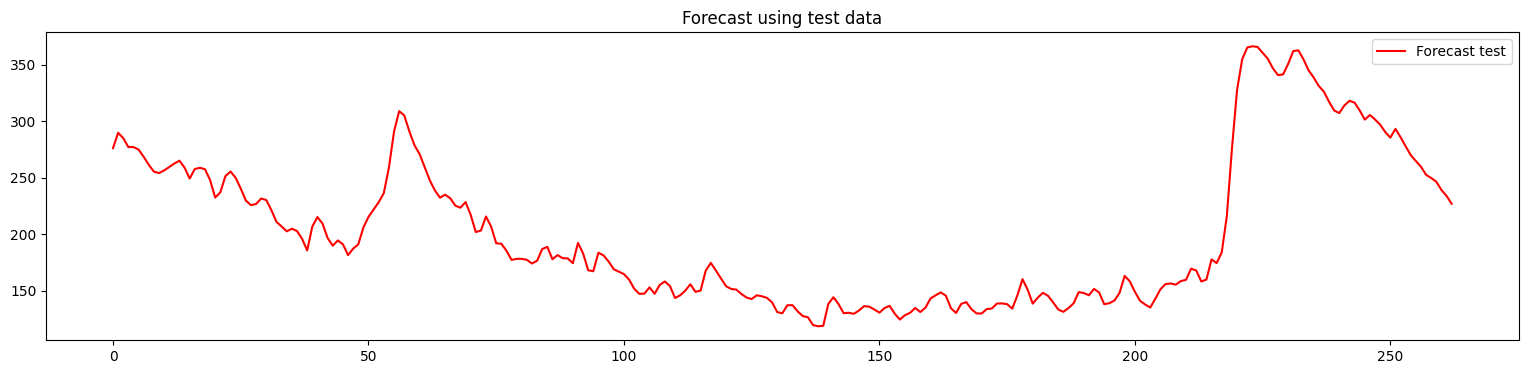

In [ ]:
plt.figure(figsize=(19, 4))
#plt.plot(index_test_normal, test_y_normal)
plt.plot(index_test, testPredict, 'red')
plt.legend(["Forecast test"])
plt.title("Forecast using test data")

Shift the predictions

In [ ]:
trainPredict.shape

(1240, 1)

In [ ]:
# shift traing predictions for plotting
trainPredictPlot = np.empty_like(data_scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(data_scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(data_scaled)-1, :] = testPredict

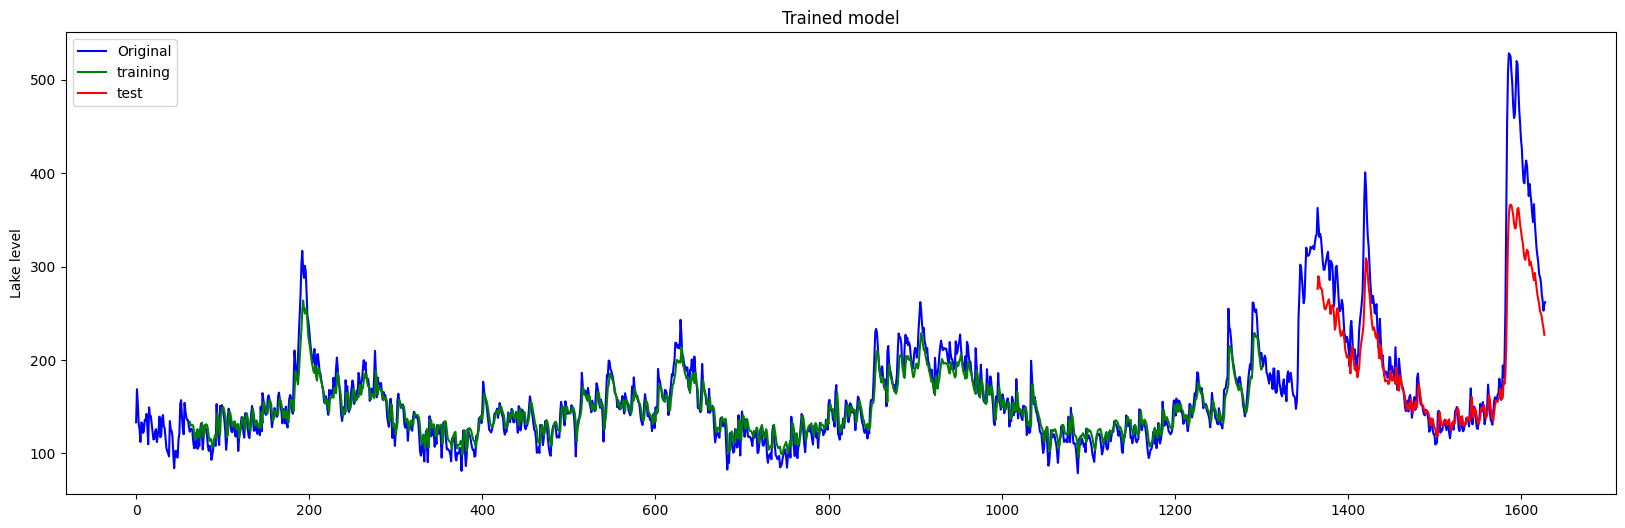

In [ ]:
# plot baseline and predictions
plt.figure(figsize=(20, 6))
plt.plot(scaler.inverse_transform(data_scaled), color='blue')
plt.plot(trainPredictPlot, color="green")
plt.plot(testPredictPlot, color='red')
plt.legend(["Original", "training", "test"])
plt.ylabel("Lake level")
plt.title("Trained model")
plt.show()

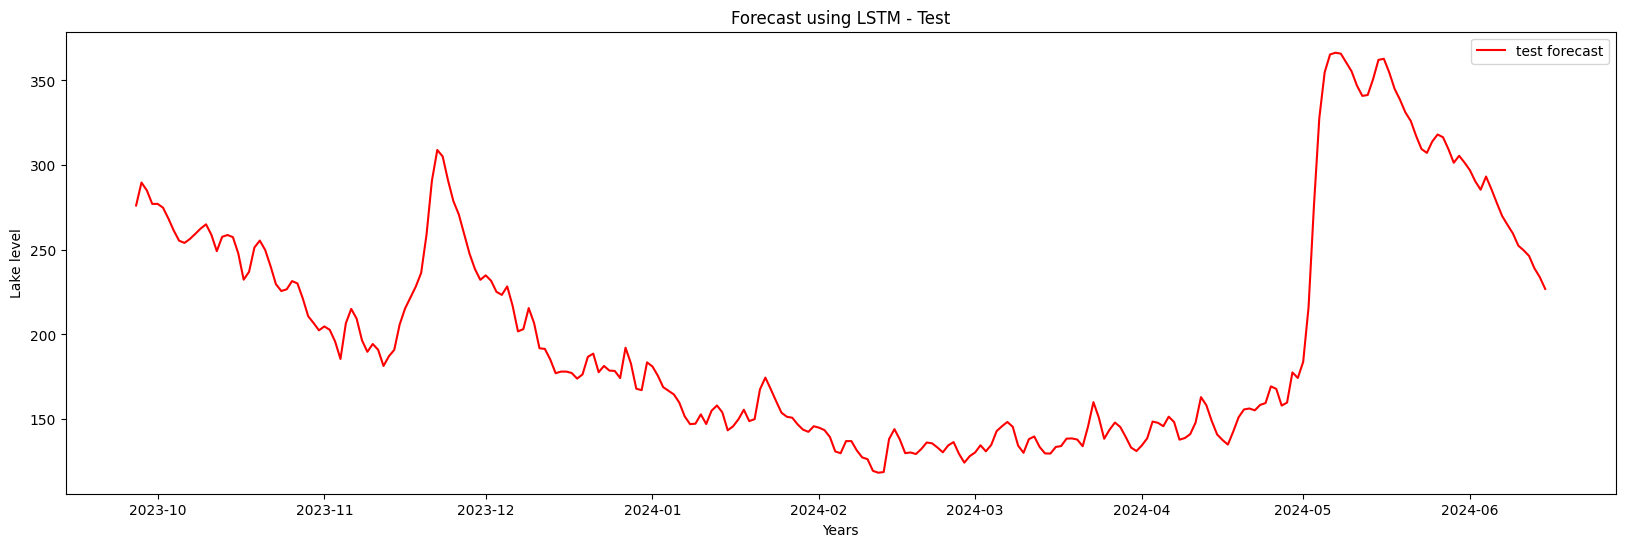

In [ ]:
# plot baseline and predictions
plt.figure(figsize=(20, 6))
plt.plot(df_daily_mean.index, testPredictPlot, color='red')
plt.legend(["test forecast"])
plt.xlabel("Years")
plt.ylabel("Lake level")
plt.title("Forecast using LSTM - Test")
plt.show()

###Non-stationary data

In [70]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(df_daily_mean.values)
data_scaled

array([[0.27471866],
       [0.27768258],
       [0.28085491],
       ...,
       [0.38718566],
       [0.40237577],
       [0.4076321 ]])

In [71]:
# split into train and test sets
train_size = int(len(data_scaled) * 0.80)
test_size = len(data_scaled) - train_size

train, test = data_scaled[0:train_size,:], data_scaled[train_size:len(data_scaled),:]
print("Treino:", len(train))
print("Teste:", len(test))

Treino: 1425
Teste: 357


In [72]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []

    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])

    return np.array(dataX), np.array(dataY)

In [73]:
# reshape into X=t and Y=t+1
look_back = 5
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [74]:
for index in range(5):
    print(trainX[index], trainY[index])

[0.27471866 0.27768258 0.28085491 0.2840967  0.28699115] 0.29064974760339
[0.27768258 0.28085491 0.2840967  0.28699115 0.29064975] 0.2920390867410735
[0.28085491 0.2840967  0.28699115 0.29064975 0.29203909] 0.29516509980086136
[0.2840967  0.28699115 0.29064975 0.29203909 0.2951651 ] 0.28469874496364556
[0.28699115 0.29064975 0.29203909 0.2951651  0.28469874] 0.2611262909276154


In [75]:
print("Train X shape: ", trainX.shape)
print("Train Y shape: ", trainY.shape)

Train X shape:  (1419, 5)
Train Y shape:  (1419,)


In [76]:
print("Test X shape: ", testX.shape)
print("Test Y shape: ", testY.shape)

Test X shape:  (351, 5)
Test Y shape:  (351,)


In [77]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [78]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model = Sequential()
model.add(GRU(1, activation='tanh', input_shape=(look_back, 1), kernel_regularizer=l2(0.001)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='tanh'))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mean_squared_error'])
model.summary()

model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2, validation_data=(testX, testY), callbacks=[early_stopping])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 1)                   │              12 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │               2 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14 (56.00 B)

 Trainable params: 14 (56.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1419/1419 - 4s - 3ms/step - loss: 0.0440 - mean_squared_error: 0.0420 - val_loss: 0.2051 - val_mean_squared_error: 0.2038
Epoch 2/20
1419/1419 - 3s - 2ms/step - loss: 0.0146 - mean_squared_error: 0.0137 - val_loss: 0.1099 - val_mean_squared_error: 0.1094
Epoch 3/20
1419/1419 - 2s - 2ms/step - loss: 0.0095 - mean_squared_error: 0.0091 - val_loss: 0.0835 - val_mean_squared_error: 0.0832
Epoch 4/20
1419/1419 - 2s - 2ms/step - loss: 0.0080 - mean_squared_error: 0.0077 - val_loss: 0.0747 - val_mean_squared_error: 0.0746
Epoch 5/20
1419/1419 - 2s - 2ms/step - loss: 0.0074 - mean_squared_error: 0.0073 - val_loss: 0.0730 - val_mean_squared_error: 0.0729
Epoch 6/20
1419/1419 - 3s - 2ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - val_loss: 0.0733 - val_mean_squared_error: 0.0733
Epoch 7/20
1419/1419 - 2s - 2ms/step - loss: 0.0070 - mean_squared_error: 0.0070 - val_loss: 0.0760 - val_mean_squared_error: 0.0760
Epoch 8/20
1419/1419 - 3s - 2ms/step - loss: 0.0069 - mean_squared_er

Predição

In [79]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


invert predictions

In [81]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])

testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

Shift data

In [82]:
# shift traing predictions for plotting
trainPredictPlot = np.empty_like(data_scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(data_scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(data_scaled)-1, :] = testPredict

Accuracy

In [83]:
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f MSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 15.33 MSE
Test Score: 43.24 RMSE


####Plot result

In [84]:
def plot_result(dataset, predict, size, title, legend_1, legend_2, color_1 = 'royalblue', color_2 = 'orangered', linestyle_1 = '-', linestyle_2 = '--'):
    plt.figure(figsize=(19, 4))
    plt.plot(dataset.tail(size).index, dataset.tail(size)['level_cm'], color=color_1, linestyle=linestyle_1)
    plt.plot(dataset.tail(size).index, predict[-size:], color=color_2, linestyle=linestyle_2)
    plt.legend([legend_1, legend_2])
    plt.title(title)

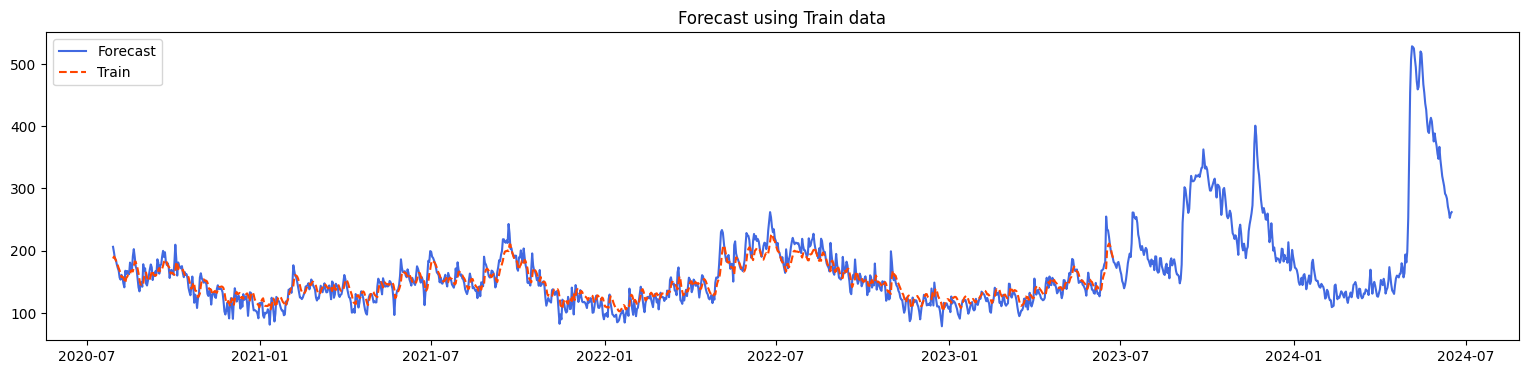

In [85]:
plot_result(df_daily_mean,
            trainPredictPlot,
            trainPredict.shape[0],
            "Forecast using Train data",
            "Forecast",
            "Train")

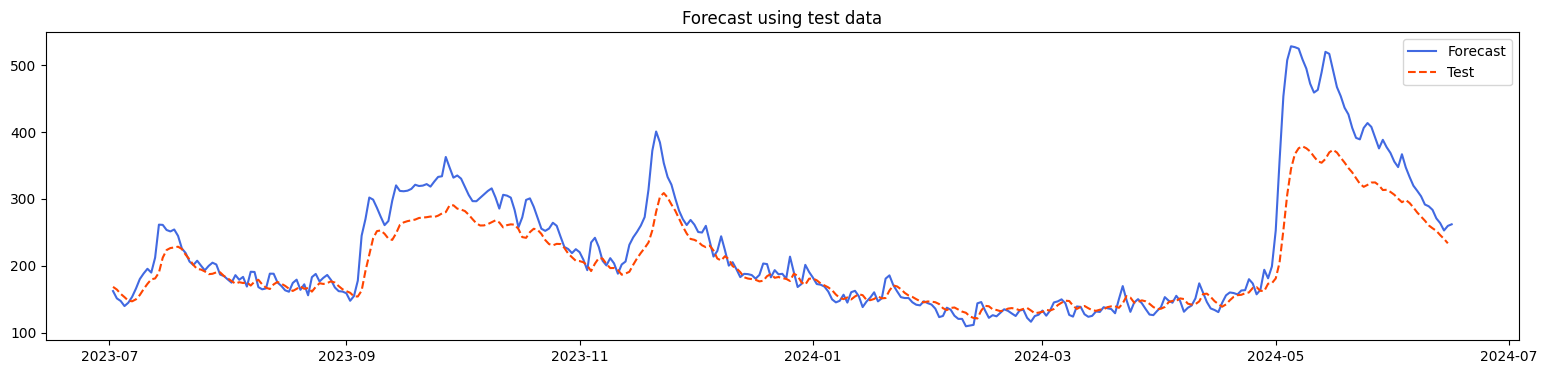

In [86]:
plot_result(df_daily_mean,
            testPredictPlot,
            testPredict.shape[0],
            "Forecast using test data",
            "Forecast",
            "Test")

Shift the predictions

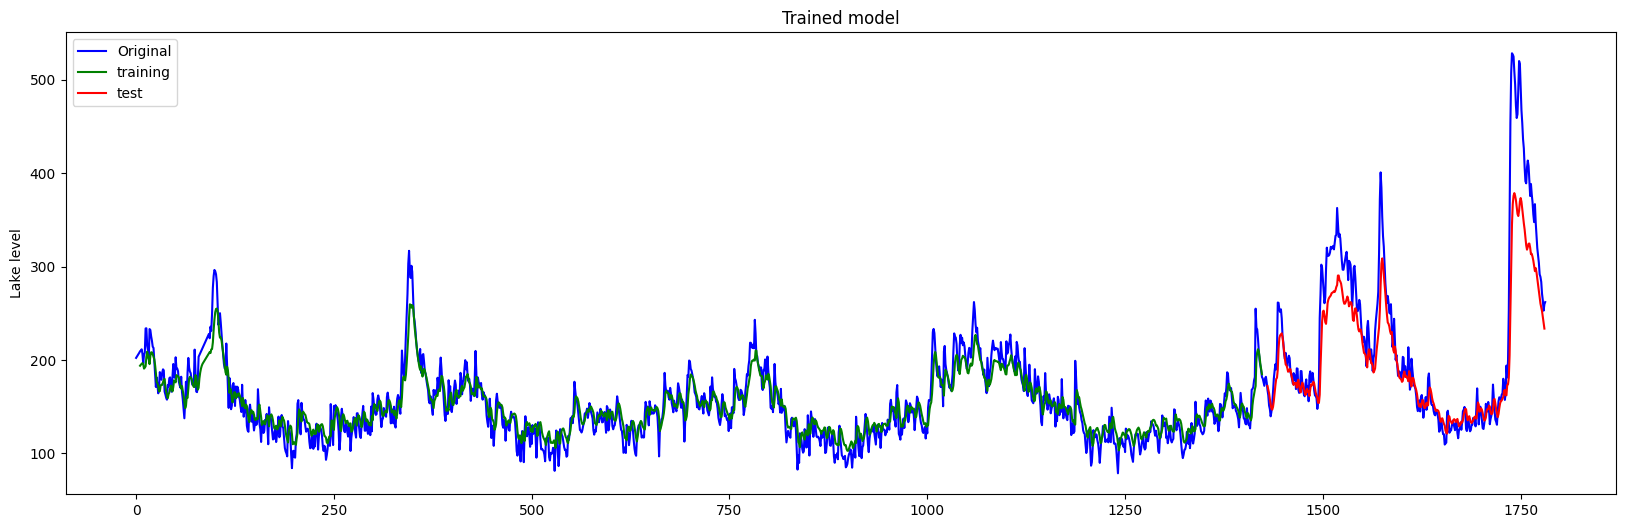

In [87]:
# plot baseline and predictions
plt.figure(figsize=(20, 6))
plt.plot(scaler.inverse_transform(data_scaled), color='blue')
plt.plot(trainPredictPlot, color="green")
plt.plot(testPredictPlot, color='red')
plt.legend(["Original", "training", "test"])
plt.ylabel("Lake level")
plt.title("Trained model")
plt.show()

#Faltando
*   Prophet
*   Montar os comparativos
*   Testar DFTS



